# La théorie du bien-être social

Auteurs : Philippe Mathieu et Antoine Nongaillard, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Creation : 18/12/2021


## Principe

Le problème présenté ici, connu sous l'acronyme **MARA** (MultiAgent Resource Allocation), rentre dans le cadre de l'affectation de ressources à un certain nombre d'agents. On considère un ensemble de ressources et un ensemble d'agents à qui l'on doit distribuer ces ressources. Les ressources considérées ici sont discrètes, indivisibles et non-partageables. Chaque agent étant autonome, il n'accorde pas la même importance aux différentes ressources que ses congénères : il exprime ses préférences au moyen d'une valeur associée à chaque ressource. Pour mesurer sa satisfaction individuelle on utilise ici une fonction d'utilité qui, pour chaque ressource, indique la valeur que l'agent lui accorde. L'agrégation des différentes valeurs associées aux ressources que possède un agent détermine sa satisfaction individuelle. D'autres considérations pourraient bien-sûr être prises en compte, nous restons ici dans un cadre simple. Le bien-être individuel d'un agent est évalué par la somme des utilités qu'il accorde aux ressources qu'il possède (on dit que les fonctions d'utilité sont additives).

La collectivité doit aussi s'accorder sur une mesure de bien-être. Pour mesurer le bien-être social, il existe 4 grandes méthodes classiques:

- Utilitaire : maximiser la somme des utilités des agents
- Egalitaire : maximiser le minimum  des utilités des agents
- Elitiste : maximiser le maximum  des utilités des agents
- Nash : maximiser le produit des utilités des agents

Le problème consiste alors à trouver comment affecter l'ensemble des ressources aux différents agents de manière à maximiser le bien-être social choisi.

Cette feuille montre comment, à l'aide d'une approche comportementale, il est possible de s'approcher voire de calculer l'optimum social.

### Comment représenter ressources et fonctions d'utilité

Afin de pouvoir jouer sur les nombres de ressources et/ou d'agents, nous générerons aléatoirement des noms de ressources afin de pouvoir en avoir autant que l'on souhaite.  Pour la fonction d'utilité, on utilisera un dictionnaire Python, dont les clés sont les ressources potentielles et les valeurs le poids que l'agent y accorde. Pour ces valeurs on prendra un entier naturel (donc sans le zero, qui évidemment pose problème lors d'un produit de Nash). Par convention, plus une ressource sera importante aux yeux d'un agent, plus la valeur qu'il lui associera sera grande.


In [2]:
import numpy as np
import pandas as pd # mainly for results
import random       # mainly for choice et randrange
# import string     # mainly for ascii_uppercase
import functools    # mainly for reduce
import copy         # mainly for deepcopy 

nb_resources =10                        # nb de ressources souhaités
valeurs = list(range(1,20))  # intervalle de valuation de chaque ressource

def genere_nom():
    return ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ') for _ in range(5))
   
# Generer une liste de ressources
ressources = [genere_nom() for _ in range(nb_resources)]
print("Un ensemble de ressources \t", ressources)

# Creer une fonction d'utilité avec des valeurs aléatoires
u = {r : random.choice(valeurs) for r in ressources}
print("Une fonction d'utilité\t" , u)

Un ensemble de ressources 	 ['HTAZA', 'UXQGP', 'XFGGY', 'IGEFH', 'LJBCY', 'PTIOG', 'VGNAW', 'MVMUB', 'CPGQD', 'JUHZB']
Une fonction d'utilité	 {'HTAZA': 6, 'UXQGP': 9, 'XFGGY': 15, 'IGEFH': 6, 'LJBCY': 17, 'PTIOG': 3, 'VGNAW': 17, 'MVMUB': 6, 'CPGQD': 19, 'JUHZB': 4}


## On passe aux agents
Un agent est défini avec le lot (`bag`) de ressources qu'il possède et une fonction d'utilité `fUtil` lui permettant de l'évaluer.
Lors de sa création, la fonction d'évalution de l'agent est définie aléatoirement. Le lot est initialement vide. La méthode `welfare` permet de connaître le bien-être individuel de l'agent, ou en d'autres termes, comment l'agent évalue son lot.

In [ ]:
class Agent:
    def __init__(self,name) :
        self.name=name
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
    def __str__(self) :
        return "agent "+str(self.name)+"  "+ str(len(self.bag)) + " resources. Individual welfare "+ str(self.welfare())
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag]) 
        

Quelques manipulations basiques sur un agent pour s'entrainer ;-)

In [ ]:
a=Agent("ag")
a.bag=random.sample(ressources,5) # choices : avec remplacement ; sample : sans remplacement

# le bag de l'agent a
print("Bag \t\t", a.bag)                              # ou sorted(a.bag)

# la fonction d'utilité de l'agent a
print("fUtil \t\t", a.fUtil)                        # ou dict(sorted(a.fUtil.items()))

# le bien-être de l'agent a
print("welfare \t", a.welfare())

# le bag avec ses valeurs
bv = [ (r,a.fUtil.get(r)) for r in a.bag]
print("valued bag \t" , bv )

# le bag valué , trié par ordre croissant des valeurs
print("valued and sorted bag \t", sorted(bv, key=lambda x: x[1]) )

# les ressources, triées par valuation (la premier est celle dont on se débarrasse le plus facilement
print("sorted resources\t",  [r for r,_ in sorted(bv, key=lambda x: x[1])]    )

On peut maintenant créer autant d'agents que l'on souhaite, leur affecter des ressources et calculer leur bien-être individuel

In [ ]:
# creer 5 agents
agentList = [Agent("ag"+str(i)) for i in range(5) ]
 
# distribuer les ressources aléatoirement
for i in range(len(ressources)) :
    random.choice(agentList).bag.append(ressources[i])

# afficher les agents
for a in agentList: print(a)

## Approche centralisée
Maintenant que les agents ont un `bag` rempli, il est maintenant possible de calculer le bien-être de cette société d'agents.
Le calcul du bien-être social consiste à agréger (selon la fonction de bien-être souhaitée) les bien-êtres individuels de chaque agent. Par exemple, le bien-être-social utilitaire correspond à la somme des bien-êtres individuels.

| nom | fn à maximiser | Caractéristique |
| -----| ----|--- |
| utilitaire | somme | équilibre global, sans tenir compte des bien-être individuels |
| égalitaire | min | permet de satisfaire un minimum de désir pour tous les agents 
| élististe | max | on donne tout à son "champion" |
| Nash | produit | réduire les écarts entre les individus, diminution des inégalités |

Notons par ailleurs que la comparaison des valeurs atteintes par ces différentes fonctions de bien-être social n'a pas de sens.

In [ ]:
print('Utilitarian Social Welfare\t', functools.reduce(lambda a, b: sum([a,b]) , [a.welfare() for a in agentList]) )
print('Egalitarian Social Welfare\t', functools.reduce(lambda a, b: min([a,b]) , [a.welfare() for a in agentList]) )
print('Elitist Social Welfare\t\t',   functools.reduce(lambda a, b: max([a,b]) , [a.welfare() for a in agentList]) )
print('Nash Social Welfare\t\t', functools.reduce(lambda a, b: np.prod([a,b]) , [a.welfare() for a in agentList]) )


### Notion d'optimal social

Parmi toutes les affectations possibles de différentes ressources, certaines fournissent la valeur maximale possible à la fonction de bien-être social. Pour certains bien-être sociaux cette affectation est facile à calculer (bien-être élitiste ou utilitaire) , pour d'autres c'est beaucoup plus compliqué. De plus, on considère ici qu'une "main invisible" (clin d'oeil à [Adam Smith](https://fr.wikipedia.org/wiki/Main_invisible)) distribue les ressources comme par magie. Si on souhaite prendre en compte les relations sociales entre les agents, cela devient compliqué même pour les fonctions d'utilité les plus simples.

##### Solution optimale pour le bien-être social élitiste
Le bien-être social **élitiste** consiste à **maximiser la richesse du plus riche** des agents (tout donner à son "champion" en quelque sorte). Quand les utilités sont 1-additives, calculer cet optimal est facile puisqu'il suffit de donner toutes les ressources à l'agents qui valorise le mieux la totalité des ressources.
La "main invisible" affecte tour à tour tous les produis à chaque agent, et regarde qui est au bien-être maximum (on pourrait imaginer faire la somme des valuations de la fonction d'utilité sans affecter les ressources, mais cela ne fonctionnerait que si une ressource n'apparaît qu'une et une seule fois).

In [ ]:
# on affecte toutes les ressources à tous les agents
for a in agentList:
    a.bag = ressources.copy()

# On recherche la plus forte évaluation
index = np.argmax([a.welfare() for a in agentList])
m = agentList[index].welfare()

print("Elitist. Optimal value : ", m,". Obtained by giving all the resources to agent ", agentList[index].name)

##### Solution optimale pour le bien-être social utilitaire
Le bien-être social **utilitaire** consiste à **maximiser la somme** des richesses de tous les agents. Calculer cet optimal est facile puisqu'il suffit de donner chaque ressource à l'agent qui la valorise le mieux.

In [ ]:
# on réinitialise les bags
for a in agentList :
        a.bag=[]

# on affecte les ressources 1 par 1 à l'agent qui la valorise le mieux               
for r in ressources :
        index = np.argmax([a.fUtil.get(r)  for a in agentList])
        ag = agentList[index]
        ag.bag.append(r)

# On fait la somme des évaluation
s = sum([a.welfare() for a in agentList])

print("Utilitarist. Optimal value : ", s ," obtained using the following affectations :")
for a in agentList :
        print(a, a.bag)   

##### Solution optimale pour les bien-êtres égalitaires ou Nash
Cette fois il n'y a pas de solution simple, même pour une "main invisible". Il faudrait tester toutes les allocations possibles. Avec `n` agents et `r` ressources il existe `n^r` affectations possibles (si on a 10 agents et 100 ressources cela fait 10^100 tests, ce qui est hors de portée des ordinateurs actuels).
On peut alors éventuellement utiliser des méthodes approximatives type _Monte-Carlo_ ou _Algorithme génétique_, mais rien ne garantit l'optimalité du résultat.

Ci-dessous une méthode de _Monte-Carlo_ pour le bien-être de Nash ...

In [ ]:
bestWelfare=-1
bestAlloc=[]
for i in range(100000):
    # on réinitialise les bags
    for a in agentList :
        a.bag=[]
    # on affecte les ressources au hasard
    for r in ressources :
        a = random.choice(agentList)
        a.bag.append(r)
    # On compare le résultat à la meilleure situation connue
    p = np.prod([a.welfare() for a in agentList])  # sum,prod,min,max
    if (p > bestWelfare):
        bestWelfare=p
        bestAlloc = {a.name:a.bag for a in agentList}
        
print("Best allocation",bestWelfare,bestAlloc)

... Une amélioration, basée sur les permutations de ressources, est possible puisque l'on sait dès le départ que pour Nash il est préférable d'équilibrer les ressources entre les agents.

In [ ]:
bestWelfare=-1
bestAlloc=[]
for i in range(100000):
    # on réinitialise les bags
    for a in agentList :
        a.bag=[]
    # on découpe les ressources en paquets égaux
    random.shuffle(ressources)
    distrib = np.array_split(ressources, len(agentList))
    for i in range(len(agentList)) :
        agentList[i].bag = distrib[i]
    # On compare le résultat à la meilleure situation connue
    p = np.prod([a.welfare() for a in agentList])  # sum,prod,min,max
    if (p > bestWelfare):
        bestWelfare=p
        bestAlloc = {a.name:a.bag for a in agentList}
        
print("Best allocation",bestWelfare,bestAlloc)

On note ici la différence entre "Individual-based system" and "agent-based system". Jusqu'à présent il y avait bien des agents, chacun avec ses propres connaissances, mais aucun comportement. Il faut la "main invisible" pour résoudre le problème. La majorité du travail algorithmique se fait hors des agents. L'approche "agent-based" est une approche comportementale: tout se passe dans le comportement de l'agent, c'est l'agent qui décide ! Il n'y a plus de "main invisible". Seul un SMA, qui n'est là que pour le strict minimum : donner la parole aux agents.


## L'approche multi-agents

L'approche centralisée présente un certain nombre de défauts :
- Avoir une affectation optimale par cette technique n'est pas toujours possible (voir ci-dessus). 
- Cette technique oblige tous les agents à indiquer à l'organe central de calcul toutes leurs utilités. La garantie d'une certaine privacité est pourtant parfois nécessaire
- La "main invisible" ! L'approche centralisée prend difficilement en compte le fait que les agents ne se connaissent pas forcément tous. Dans la vraie vie, les connaissances des individus dessinent un graphe social

Par opposition, l'approche multi-agents possède plusieurs avantages :
- Une approche multi-agents peut être implémentée avec une programmation distribuée. Dans ce cas les communications sont asynchrones par envoi de message avec accusés de réception et dead line pour la robustesse. C'est via ces communications qu'un agent peut être informé de l'état du système ou plus particulièrement de l'état de ses accointances.
- Dans une exécution distribuée, des échanges de ressources peuvent avoir lieu de manière concurrente entre différents couples d'agents."
- L'approche distribuée est évidemment bien plus conforme aux situations réelles.


Nous étudions par la suite une approche comportementale qui permet aux agents d'échanger des ressources pour améliorer le bien-être social. Chaque agent tour à tour peut effectuer certains échanges avec ces accointances fidèles à un type de réseau social. On peut alors voir peu à peu le bien-être social évoluer. L'important maintenant, n'est plus "quel est l'optimum ?", mais "comment on arrive à l'optimum ?".


##### Tout d'abord réalisons le SMA, le réseau social et l'agent ... 
- Cette fois, c'est le SMA qui crée les agents, dans son constructeur.
- Les agents sont initialement créés vides.
- Des méthodes permettent d'affecter aux agents des accointances ou des ressources. Ceci permettra pas la suite de relancer le même SMA soit avec la même affectation de ressources, soit avec le même réseau social, soit les deux.

##### Le réseau social

Comme dans [mas_basics]() on utilisera la librairie [networkx](https://networkx.org/) qui contient de nombreuses fonctions de création de graphes et permet de récupérer avec sa fonction `to_numpy_array` une matrice d'adjacence.

In [ ]:
import networkx as nx

nb_nodes = 20
graph = nx.barabasi_albert_graph(nb_nodes, 2)
#graph = nx.complete_graph(nb_nodes)
#graph = nx.erdos_renyi_graph(nb_nodes,0.6)
#graph = nx.cycle_graph(nb_nodes)
#graph = nx.random_regular_graph(3,nb_nodes)
matrix = nx.to_numpy_array(graph, nodelist=range(nb_nodes))

Et pour la représentation graphique ...

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # pour définir la taille de la figure
nx.draw_networkx(graph)
plt.axis('off')
plt.show()

#### L'agent et le SMA
Pour créer un SMA on lui passe simplement le nombre d'agents souhaité. C'est le SMA qui crée les agents. La méthode `setResources` permet d'affecter les ressources aux agents (via une liste de listes décrivant les `bag`des agents). La méthode `setAccointances` établit la structure du réseau social via une matrice d'adjacence (sous forme d'une liste de listes obtenue facilement à partir d'un graphe networkx).
L'agent est initialement créé sans accointance ni ressource, mais il a déjà sa fonction d'utilité.
Attention : dans le code suivant, recréer un SMA recrée aussi les fonctions d'utilité de chacun !

De nombreux comportements peuvent être mis en place. Sur le nombre de participants à un échange (on en reste ici à 2 : négociation bi-latérale), sur le type d'échange autorisé (échange d'une ressource contre une autre (swap) ou don d'une ressource sans contre-partie (gift)), ou sur l'ordre dans lequel on propose ces échanges. Même en se focalisant sur le swap il y a encore 3 grandes familles (`swap_kind`):
- les irrationnels : ils échangent n'importe quoi avec n'importe qui, sans rien vérifier
- les rationnels : l'échange ne se fait que si tous les deux y gagnent individuellement. Le don n'a pas de sens pour eux.
- les sociaux : l'échange ne se fait que si la société y gagne. Ce qui se produit pour certains dons, mais pas pour tous !

Par ailleurs, dans les trois cas précédents il est encore possible de s'y prendre de 2 manières différentes (`behavior_kind`)
- Priorité à la ressource : on prend sa pire ressource et on cherche un ami avec qui on fera l'échange ; si on a fait le tour de ses amis sans succès, alors seulement on change de ressource. 
- Priorité à l'ami : on choisit un ami et on cherche une ressource à lui échanger ; si on a fait le tour de toutes les ressources sans succès avec cet ami, alors seulement on change d'ami.


Dans l'implémentation qui suit et pour des raisons de simplification, on fait appel à l'objet `sma` pour connaître le bien être social,
ce qui est contradictoire avec la décentralisation du processus.
Notons que pour le calcul du bien être social, connaître la variation des utilités des 2 agents qui s'échangent des ressources
est parfois suffisant pour en déduire que le bien être social (donc de l'ensemble du système) est amélioré ou pas.
Ceci fait l'objet de l'exercice 4.

TODO: Structuration du comportement.


In [1]:
%run socialWelfareSrc.py


#### Une premiere expérience

Comme premiere experience, nous nous basons sur le comportement le plus simple qui soit. Les agents peuvent mettre en jeu une seule ressource à la fois. Ils sont irrationnels (donc acceptent n'importe quelle proposition), et ils choisissent aléatoirement l'article qu'ils échangent et l'ami avec qui ils échangent. Le graphe social est complet (un agent connaît toute la population).


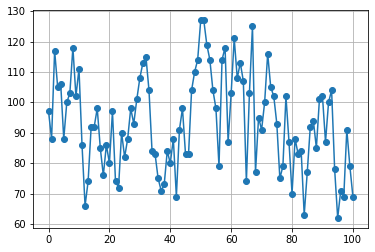

In [6]:
import networkx as nx
import matplotlib.pyplot as plt


# paramétrage de l'experience
nb_agents=5
nb_resources=10
# intervalle de valuation de chaque ressource
valeurs = list(range(1,20))
graph = nx.complete_graph(nb_agents)
m = nx.to_numpy_array(graph, nodelist=range(nb_agents))
# Generation d'une liste de ressources
resources = [genere_nom() for _ in range(nb_resources)]

# Creation du SMA
sma = SMA(nb_agents, welfare='Utilitarist', behavior_kind='random2', swap_kind='irrational', resources = resources, valeurs = valeurs, maxEx = 1)
sma.setAccointances(m)
sma.setResources(resources)



# lancement experience
sma.run(100)
plt.plot(sma.history,'-o')
plt.grid()
plt.show()


In [7]:
#### Une seconde expérience

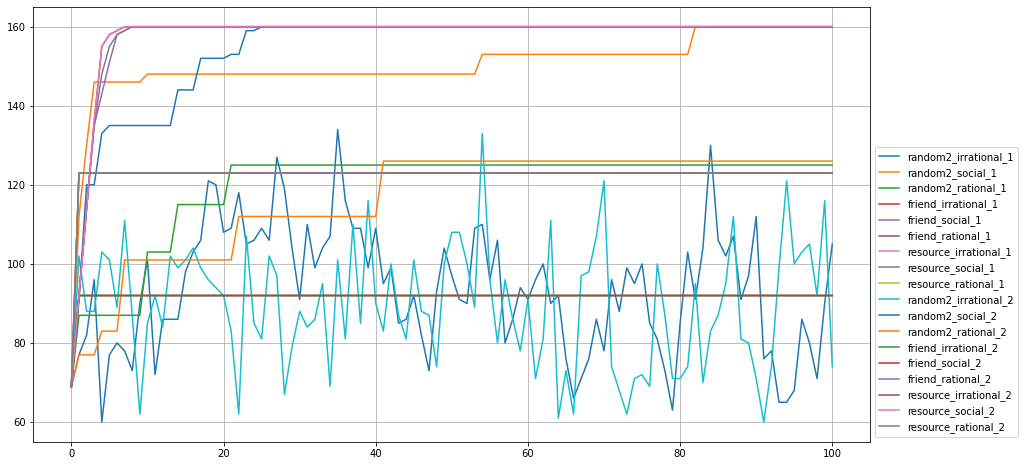

In [10]:
sma1 = sma
data=pd.DataFrame()
for i in range(2) : 
    # On recupere les noms des fonctions definissant le comportement dans le fichier Decisions
    for b in ['random2','friend','resource'] :
        # On recupere les noms des fonctions definissant l'acceptabilité d'un echange dans le fichier Acceptabilities
        for s in ['irrational','social','rational'] :    
            sma2 = copy.deepcopy(sma1)
            sma2.redefineSMA()
            sma2.setGlobalMaxEx(i+1)
            sma2.setGlobalBehaviorKind(b)
            sma2.setGlobalSwapKind(s)
            sma2.run(100)
            data[b+'_'+s+"_"+str(i+1)]=sma2.history
            data[b+'_'+s+"_"+str(i+1)].plot(figsize=(15,8), grid=True, alpha=1, linestyle = '-')
plt.legend(loc=3,bbox_to_anchor=(1,0))
plt.show()


#### Tracé de l'évolution du social welfare
Une fois l'expérience réalisée, il est alors possible de tracer l'évolution du social Welfare

On peut bien sûr comparer les comportements en jouant sur les paramètres `behavior_kind` et/ou `swap_kind`. Afin de s'assurer que l'on utilise exactement les mêmes affectations d'amis et de ressources, on clone le sma à chaque tour.
On prendra garde à la constitution des points de la courbe : si on loggue l'évolution du welfare à chaque changement (dans les méthodes `swap` par exemple), il n'y aura pas les mêmes valeurs collectées; pour assurer le même nombre de valeurs et donc des courbes comparables, on ne loggue qu'à chaque fin de tick (donc dans `runOnce`)

NameError: name 'nx' is not defined

# Exercices

1. Dans le code précédent, le comportement est soit swap soit don. Or le don n'est jamais qu'un swap avec une ressource vide. Comment modifier le swap pour qu'il intègre le don ? Bien évidemment ce don n'a pas de sens pour un agent rationnel puisque si les utilités sont toutes positives, l'agent fait baisser son utilité en donnant.
1. Comme le hasard intervient dans chaque expérience (distribution initiale des ressources, graphe s'il n'est pas complet), il est important de pouvoir répéter les mesures afin de moyenner les résultats. 
Tracer un tableau indiquant le nombre de victoires pour les 6 cas précédents répétés 100 fois. 
1. Précédemment, nous avons présenté 4 mesures de bien-être social. Que donne le Leximin ? Le leximin consiste à maximiser dans l'ordre lexicographique les vecteurs des utilités de chaque agent classées du min au max
1. Dans le code du swap social, on teste l'augmentation de l'utilité sociale en utilisant la classe `sma`. A priori l'agent ne connait que ses accointances. Il ne devrait pas pouvoir accès à tous les agents, donc pas à la classe sma. On triche !. Comment mettre en place des critères locaux permettant de savoir si le bien être social augmente sans avoir accès à tout le monde ?
1. le type de graphe
    - Est-ce que des phénomènes spécifiques se produisent selon la forme du graphe ou le taux de connectivité moyen ?
1. le type d'échange accepté
    - Actuellement il n'y a que des échanges de taille 0 ou 1. Qu'est-ce que cela change d'accepter des échanges de 2 ou 3 ressources en même temps ?
1. Les agents sont pour l'instant tous homogènes. Ils appliquent tous le même comportement. Qu'est-ce que ça donne si la population est hétérogène ?



# Bibliographie
- Moulin, H. (2004). Fair division and collective welfare. MIT press.
- Chevaleyre Y, Endriss U, Lang J, Maudet N (2005) Negotiating over small bundles of resources. In: AAMAS’05, pp 296–302
- Nongaillard, A., & Mathieu, P. (2014). Agent-based reallocation problem on social networks. Group Decision and Negotiation, 23(5), 1067-1083.
- Delahaye, J. P., & Mathieu, P. (2009). La répartition idéale des biens existe-t-elle?. Pour la science, 381, 88-93.
- Ferber J. (1995). Systèmes Multi-Agents, vers une intelligence collective. InterEditions. [en ligne ici](http://www.lirmm.fr/~ferber/publications/LesSMA_Ferber.pdf)

In [ ]:
print('Leximin Social Welfare\t\t', sorted([a.welfare() for a in agentList]) )
 
# 1 if a<b ; -1 if b<a ; 0 if a==b
def leximin(a,b) :
    for i in range(len(a)) :
        if (a[i]>b[i]) :
           return 1
        elif (a[i]<b[i]) :
           return -1
    return 0

x=np.array([1,2,3,4])
y=np.array([1,1,3,4])
leximin(x,y) 

In [5]:
#****** ANCIENNE VERSION ******

class SMA:
    def __init__(self, nb_agents, welfare, behavior_kind , swap_kind):
        self.agentList = [Agent(i, self, behavior_kind, swap_kind) for i in range(nb_agents)]
        self.welfare_type=welfare
        self.tick=0
        self.history=[]

    def __str__(self) :
        s=""
        for i in range(len(self.agentList)):
            s=s+(self.agentList[i].__str__()+"\n")
        s=s+("Social Welfare : " + str(self.socialWelfare())) 
        return(s)

    def setRessources(self,init_affect) :
        if (len(init_affect) != len(self.agentList)) :
            raise ValueError("Problem of size in setRessources :", len(init_affect), len(agentList))
        for i in range(len(self.agentList)) :
            self.agentList[i].bag=init_affect[i]

    def setAccointances(self,adjacency_matrix) :
        if (len(adjacency_matrix[0]) != len(self.agentList)) :
            raise ValueError("Problem of size in setAccointances :", len(adjacency_matrix[0]) , len(agentList))
        for i in range(len(self.agentList)) :
            self.agentList[i].accointances = np.nonzero(adjacency_matrix[i])[0]

    def run(self, rounds):
        self.tick=0
        self.history=[]
        self.history.append(self.socialWelfare())
        for i in range(0,rounds):
            self.runOnce()
    
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick)
        print("tick " + str(self.tick) + " ended")
        self.history.append(self.socialWelfare())
        print("Le Welfare actuel est de ", self.socialWelfare())

    def socialWelfare(self):
        if self.welfare_type.upper()=='UTILITARIST':
            return sum([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='EGALITARIST':
            return min([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='ELITIST':
            return max([a.welfare() for a in self.agentList])
        elif self.welfare_type.upper()=='NASH':
            return np.prod([a.welfare() for a in self.agentList])
        else :
            raise ValueError("Unknown method in socialWelfare")



# L'agent est le même que précédemment excepté qu'il a maintenant ses propres accointances, sa fonction d'Utilité
# et une méthode de décision avec différents échanges possibles
# Par défaut il n'a ni ressources ni accointances
class Agent:
    def __init__(self, name, sma, behavior_kind, swap_kind) :
        self.name=name
        self.sma = sma
        self.swap_kind = swap_kind
        self.behavior_kind = behavior_kind
        self.fUtil = {r : random.choice(valeurs) for r in ressources}
        self.bag = []
        self.accointances = []
    def __str__(self) :
        return "agent "+str(self.name)+" Welfare :"+ str(self.welfare())+"\tbag :"+ str(self.bag)
    def welfare(self):
        return sum([self.fUtil.get(r) for r in self.bag])
    def getSortedBag(self):
        bagval = [ (r,self.fUtil.get(r)) for r in self.bag]
        return [r for r,_ in sorted(bagval, key=lambda x: x[1])]

    def gift(self):    
        # choisir une accointance au hasard
        friend = self.sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # donner cette ressource à l'accointance
        self.bag.remove(r)
        friend.bag.append(r)
        print(self.name, "donne la ressource ",r," à l'agent ",friend.name)

    # IRRATIONAL : swap sans aucune contrainte
    def swap1(self):
        # choisir une accointance au hasard
        friend = self.sma.agentList[np.random.choice(self.accointances)]
        # choisir une de ses propres ressources au hasard
        r = np.random.choice(self.bag)
        # choisir une des ressources de l'autre au hasard
        if len(friend.bag)==0 :
            return
        s = np.random.choice(friend.bag)
        # echanger les ressources
        self.bag.remove(r)
        friend.bag.remove(s)
        friend.bag.append(r)
        self.bag.append(s)
        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
    
    # PRIORITE RESSOURCE : on choisit une ressource et on teste tous les amis avec
    # trois cas possibles : swap_kind = irrational, rational, social
    def swap2(self) :
        # je propose mes ressources par intérêt décroissant (donc valeur croissante)
        for r in self.getSortedBag() :
            # à chacun de mes amis
            for f in self.accointances :
                friend = self.sma.agentList[f]
                for s in  friend.bag :
                    # on teste si c'est mieux pour les deux
                    # UTILISER sma N'EST PAS TRES "AGENT" , NEANMOINS DES CRITERES LOCAUX EXISTENT
                    actualSocialWelfare = self.sma.socialWelfare()
                    actualMyWelfare = self.welfare()
                    actualFriendWelfare = friend.welfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    # For irrational (equiv to swap1 ; swap1 is a simplified version)
                    if self.swap_kind.upper()=='IRRATIONAL' :
                        return
                    # For rational welfare
                    if self.swap_kind.upper()=='RATIONAL' and self.welfare() > actualMyWelfare and friend.welfare() > actualFriendWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind +" : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return                       
                    # For social welfare
                    if self.swap_kind.upper()=='SOCIAL' and self.sma.socialWelfare() > actualSocialWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind + " : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return
                    # Si les IF ne fonctionnent pas, on remet tout en place
                    self.bag.remove(s)
                    friend.bag.remove(r)
                    friend.bag.append(s)
                    self.bag.append(r)
    
    # PRIORITE FRIEND : on choisit un ami, et on teste toutes les ressources
    # trois cas possibles : swap_kind = irrational, rational, social
    def swap3(self) :
        # je parcours mes amis
        for f in self.accointances :
            friend = self.sma.agentList[f]
            # puis je propose mes ressources par intérêt décroissant (donc valeur croissante)
            for r in self.getSortedBag() :
                for s in  friend.bag :
                    # on teste si c'est mieux pour les deux
                    # UTILISER sma N'EST PAS TRES "AGENT" , NEANMOINS DES CRITERES LOCAUX EXISTENT
                    actualSocialWelfare = self.sma.socialWelfare()
                    actualMyWelfare = self.welfare()
                    actualFriendWelfare = friend.welfare()
                    self.bag.remove(r)
                    friend.bag.remove(s)
                    friend.bag.append(r)
                    self.bag.append(s)
                    # For irrational (equiv to swap1 ; swap1 is a simplified version)
                    if self.swap_kind.upper()=='IRRATIONAL' :
                        return
                    # For rational welfare
                    if self.swap_kind.upper()=='RATIONAL' and self.welfare() > actualMyWelfare and friend.welfare() > actualFriendWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind +" : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return                       
                    # For social welfare
                    if self.swap_kind.upper()=='SOCIAL' and self.sma.socialWelfare() > actualSocialWelfare :
                        print(self.name, "echange ",r," contre ",s, " avec ",friend.name)
                        print(self.swap_kind + " : Welfare passe de ",actualSocialWelfare," à ", self.sma.socialWelfare())
                        #self.sma.history.append(self.sma.socialWelfare())
                        return
                    # Si les IF ne fonctionnent pas, on remet tout en place
                    self.bag.remove(s)
                    friend.bag.remove(r)
                    friend.bag.append(s)
                    self.bag.append(r)

    def decide(self,tick):
        # pour faire qq chose il faut au moins avoir des ressources et des amis
        if (len(self.accointances)==0 or len(self.bag)==0) :
            return
        # s'écrit avec match-case à partir de python 3.10
        if   self.behavior_kind.upper()=='GIFT'       : self.gift()
        elif self.swap_kind.upper()=='IRRATIONAL' : self.swap1()
        elif self.behavior_kind.upper()=='RESSOURCE'  : self.swap2()
        elif self.behavior_kind.upper()=='FRIEND'     : self.swap3()
        else : 
            raise ValueError("Impossible behavior in decide")
                